# Requirements

In [720]:
!pip install pmdarima
!pip install chart_studio
!pip install statsmodels --upgrade

# Installation & Import of required libraries

In [721]:
from google.colab import drive,files # accesing google disk
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from chart_studio.plotly import plot_mpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA # for previous versions use statsmodels.tsa.arima_model.ARIMA 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive,files
plt.style.use('fivethirtyeight') 
pd.set_option('display.max_columns', None)
drive.mount('/drive', force_remount=False)
print("Google Drive was mounted")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Google Drive was mounted


# Structure Investigation

In [722]:
df = pd.read_csv('/drive/MyDrive/TimeSeries project/Aquifer_Petrignano - Aquifer_Petrignano.csv')
df = df.dropna()
df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis = 1, inplace = True) 
df.head().style.background_gradient(cmap='Blues')

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
1024,01/01/2009,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1025,02/01/2009,0.000000,-31.110000,2.300000,-28785.888000,2.500000
1026,03/01/2009,0.000000,-31.070000,4.400000,-25766.208000,2.400000
1027,04/01/2009,0.000000,-31.050000,0.800000,-27919.296000,2.400000
1028,05/01/2009,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


In [723]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.rename(columns={"Date":'date',
                   'Rainfall_Bastia_Umbra':'rainfall',
                   'Depth_to_Groundwater_P25':"depth_to_groundwater",
                   "Temperature_Bastia_Umbra":"temperature",
                   "Volume_C10_Petrignano":"volume",
                   "Hydrometry_Fiume_Chiascio_Petrignano":'hydrometry'
                   }, inplace=True, errors='ignore')
target = df['depth_to_groundwater']

df.head().style.background_gradient(cmap='Blues')

,date,rainfall,depth_to_groundwater,temperature,volume,hydrometry
1024,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1025,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
1026,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
1027,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
1028,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


In [724]:
df.describe().style.background_gradient(cmap='Blues')

,rainfall,depth_to_groundwater,temperature,volume,hydrometry
count,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000
mean,1.554723,-25.177504,15.046747,-28647.225785,2.370265
std,5.232954,2.951859,7.803718,4573.361338,0.591042
min,0.000000,-33.710000,-3.700000,-41890.176000,0.000000
25%,0.000000,-26.877500,8.800000,-31065.768000,2.100000
50%,0.000000,-25.145000,14.700000,-28375.056000,2.400000
75%,0.000000,-23.262500,21.400000,-26028.864000,2.700000
max,67.300000,-19.100000,33.000000,0.000000,4.100000


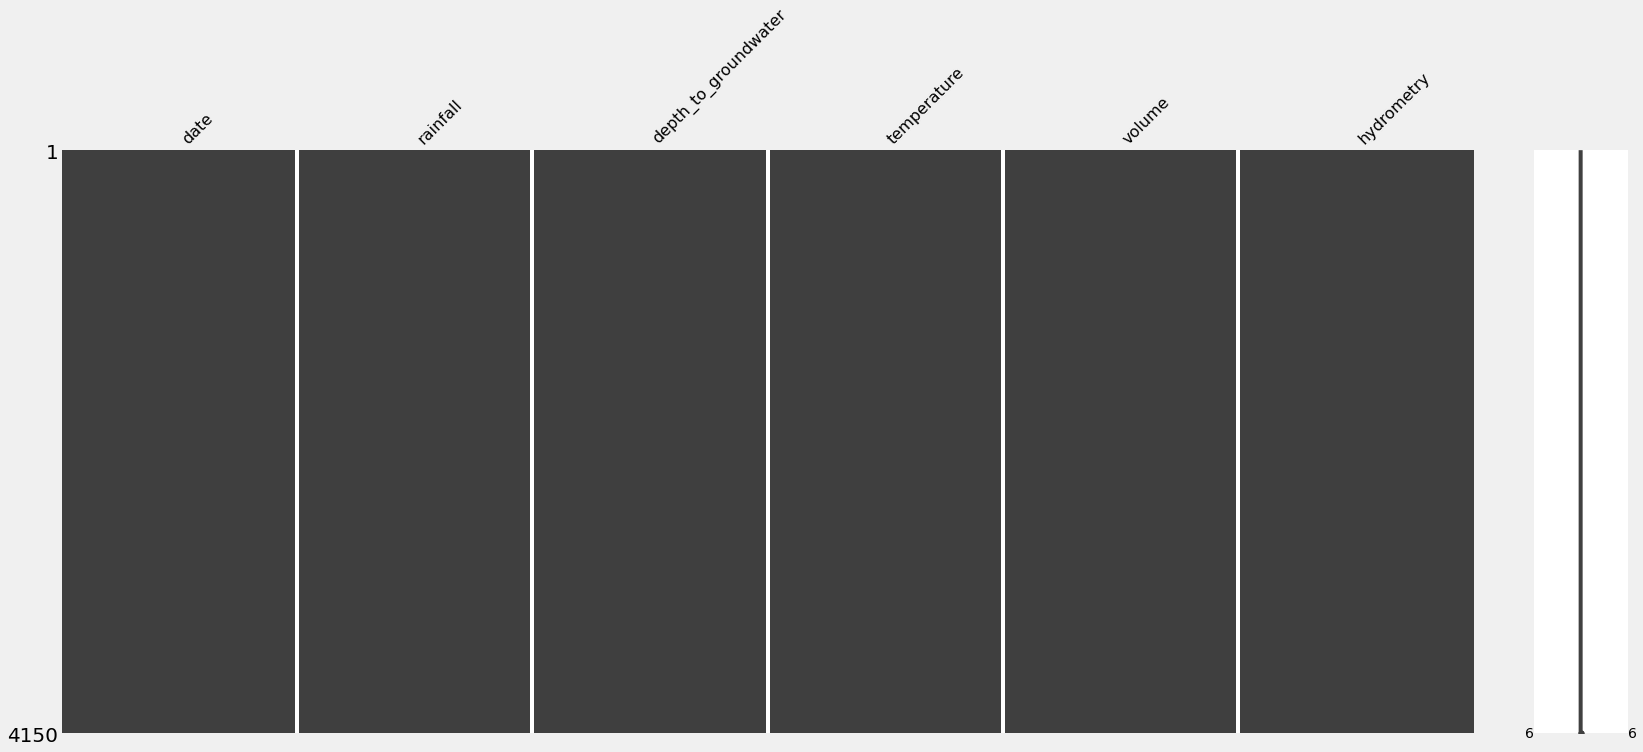

In [725]:
msno.matrix(df)

In [726]:
features = [i for i in df.columns if i not in target ]

print("Starting date:", df['date'].iloc[0])
print("Ending date:", df['date'].iloc[-1])
print("Dataframe shape ---->", df.shape)
print("Dataframe num of dimensions ---->", df.ndim )

Starting date: 2009-01-01 00:00:00
Ending date: 2020-06-30 00:00:00
Dataframe shape ----> (4150, 6)
Dataframe num of dimensions ----> 2


Let's check chronological order of dataframe

In [727]:
df = df.sort_values(by='date')

df['difference'] = df['date'] - df['date'].shift(1)

df['difference'].sum(), df['difference'].count()

(Timedelta('4198 days 00:00:00'), 4149)

In [728]:
df.drop('difference', axis=1, inplace=True) # dropping back  temp difference feature

Volume & Hydrometry seems to have some days when values were equal to zero, by exploring given dataset more in-depth, nature of Volume values could be explained that devices and equipment were off or broken those days, therefore it recorded zero values

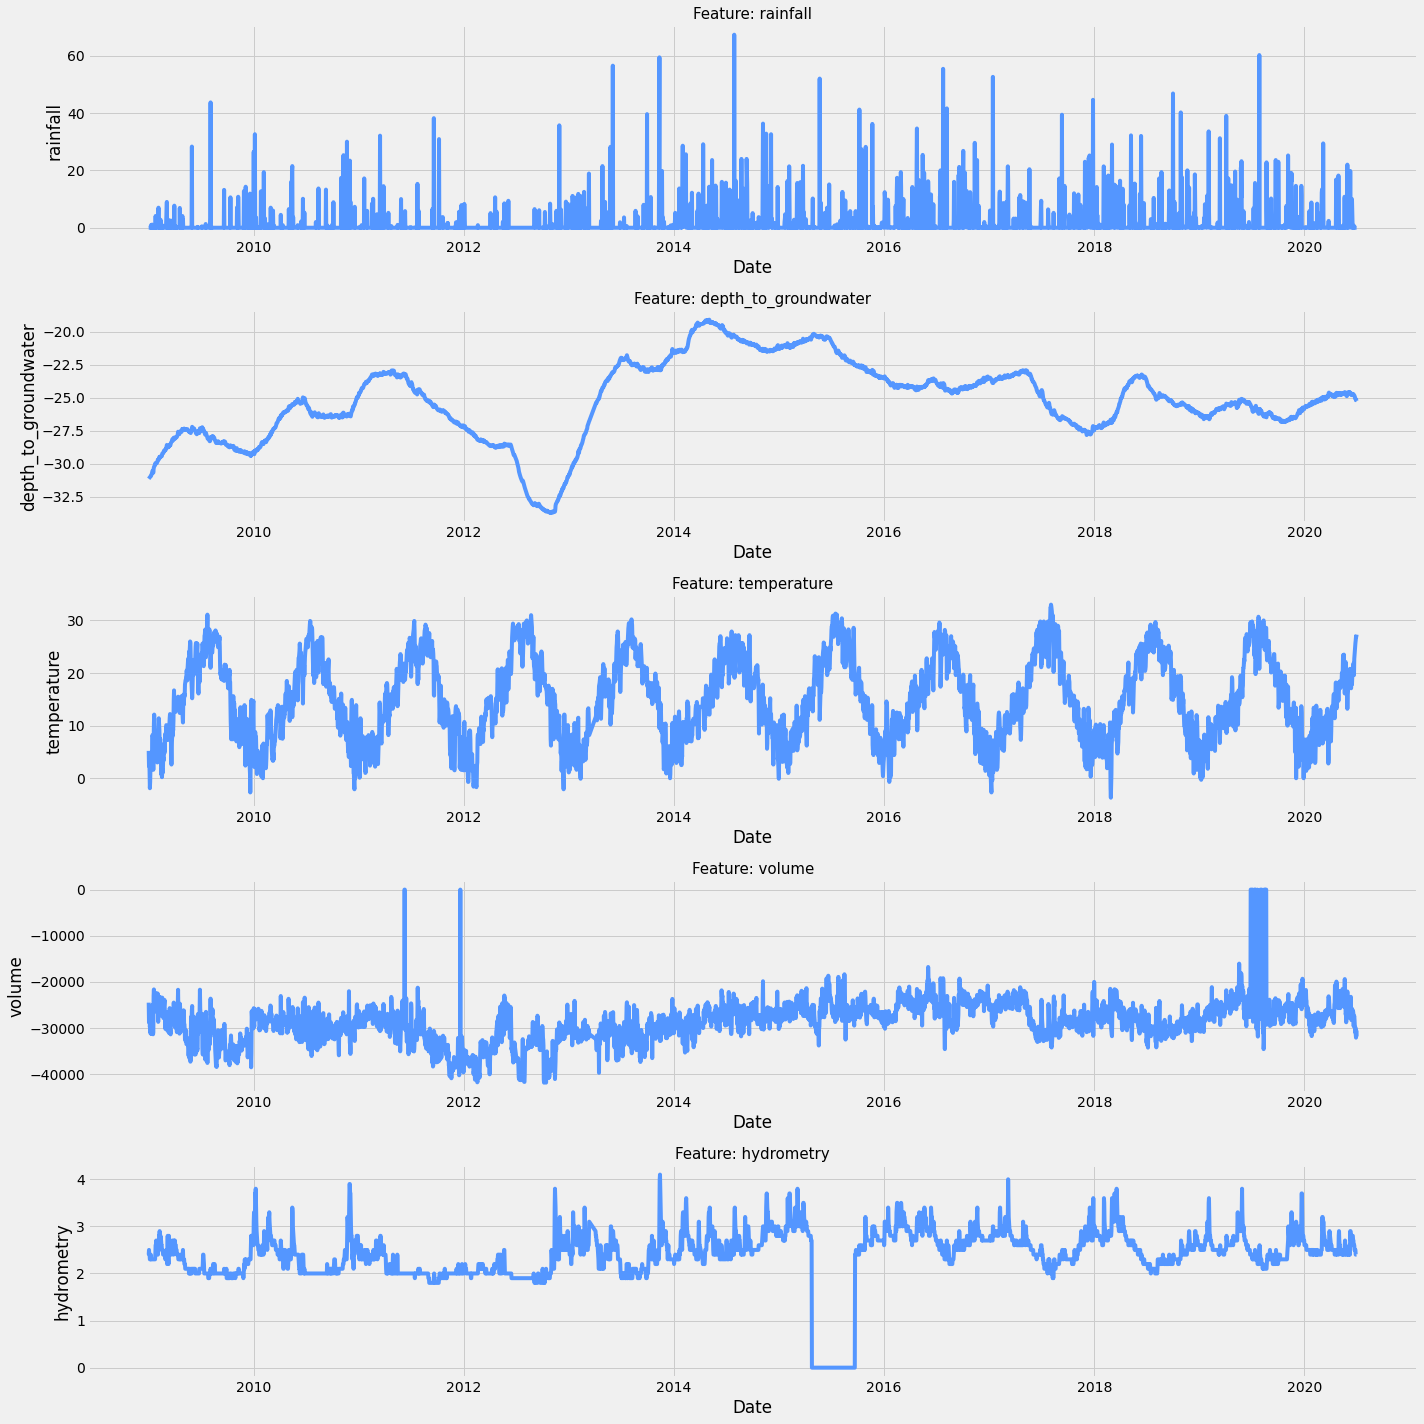

In [729]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,20))

for i, column in enumerate(df.drop('date', axis=1).columns):
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), color='#5496ff',
               ax=ax[i])
  ax[i].set_title('Feature: {}'.format(column), fontsize=15)
  ax[i].set_xlabel("Date")
  plt.tight_layout()

Interpolating missing values

In [730]:
df['volume'] = df['volume'].interpolate()
df['hydrometry'] = df['hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

# Visualization of target time series data

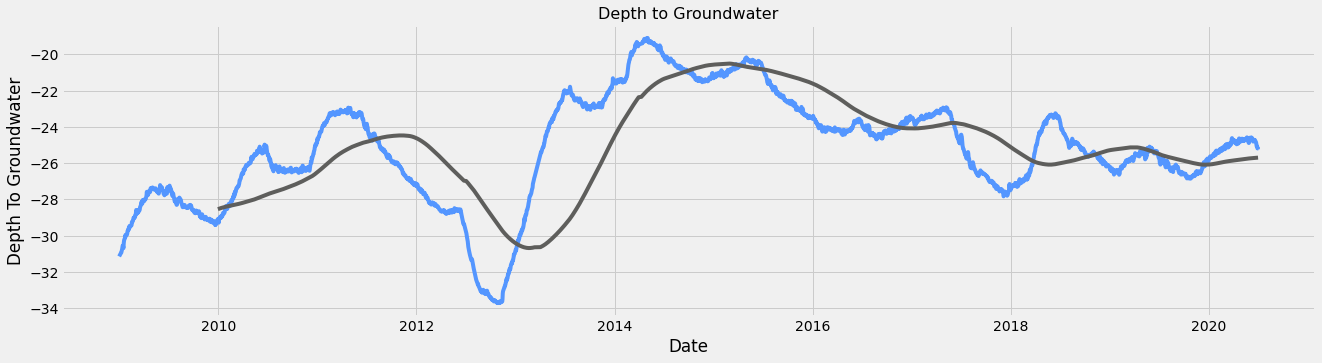

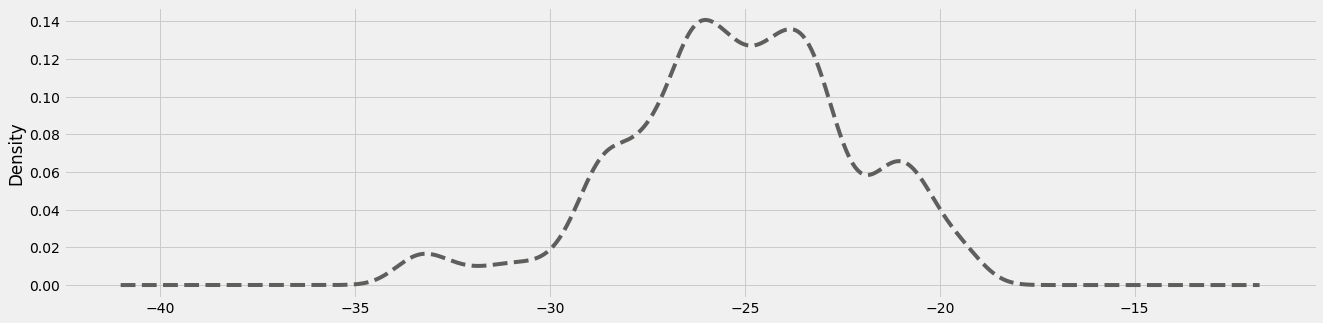

In [731]:
plt.figure(figsize=(20,5))
sns.lineplot(x=df['date'], y=target, color='#5496ff')
sns.lineplot(x=df['date'], y=target.rolling(365).mean(), color='#5e5e5c')

plt.xlabel("Date")
plt.ylabel("Depth To Groundwater")
plt.title("Depth to Groundwater", fontsize=16)
plt.figure(figsize=(20,5))
target.plot(kind='kde', color='#5e5e5c', style='--') # KDE plot

plt.show()

# Resampling

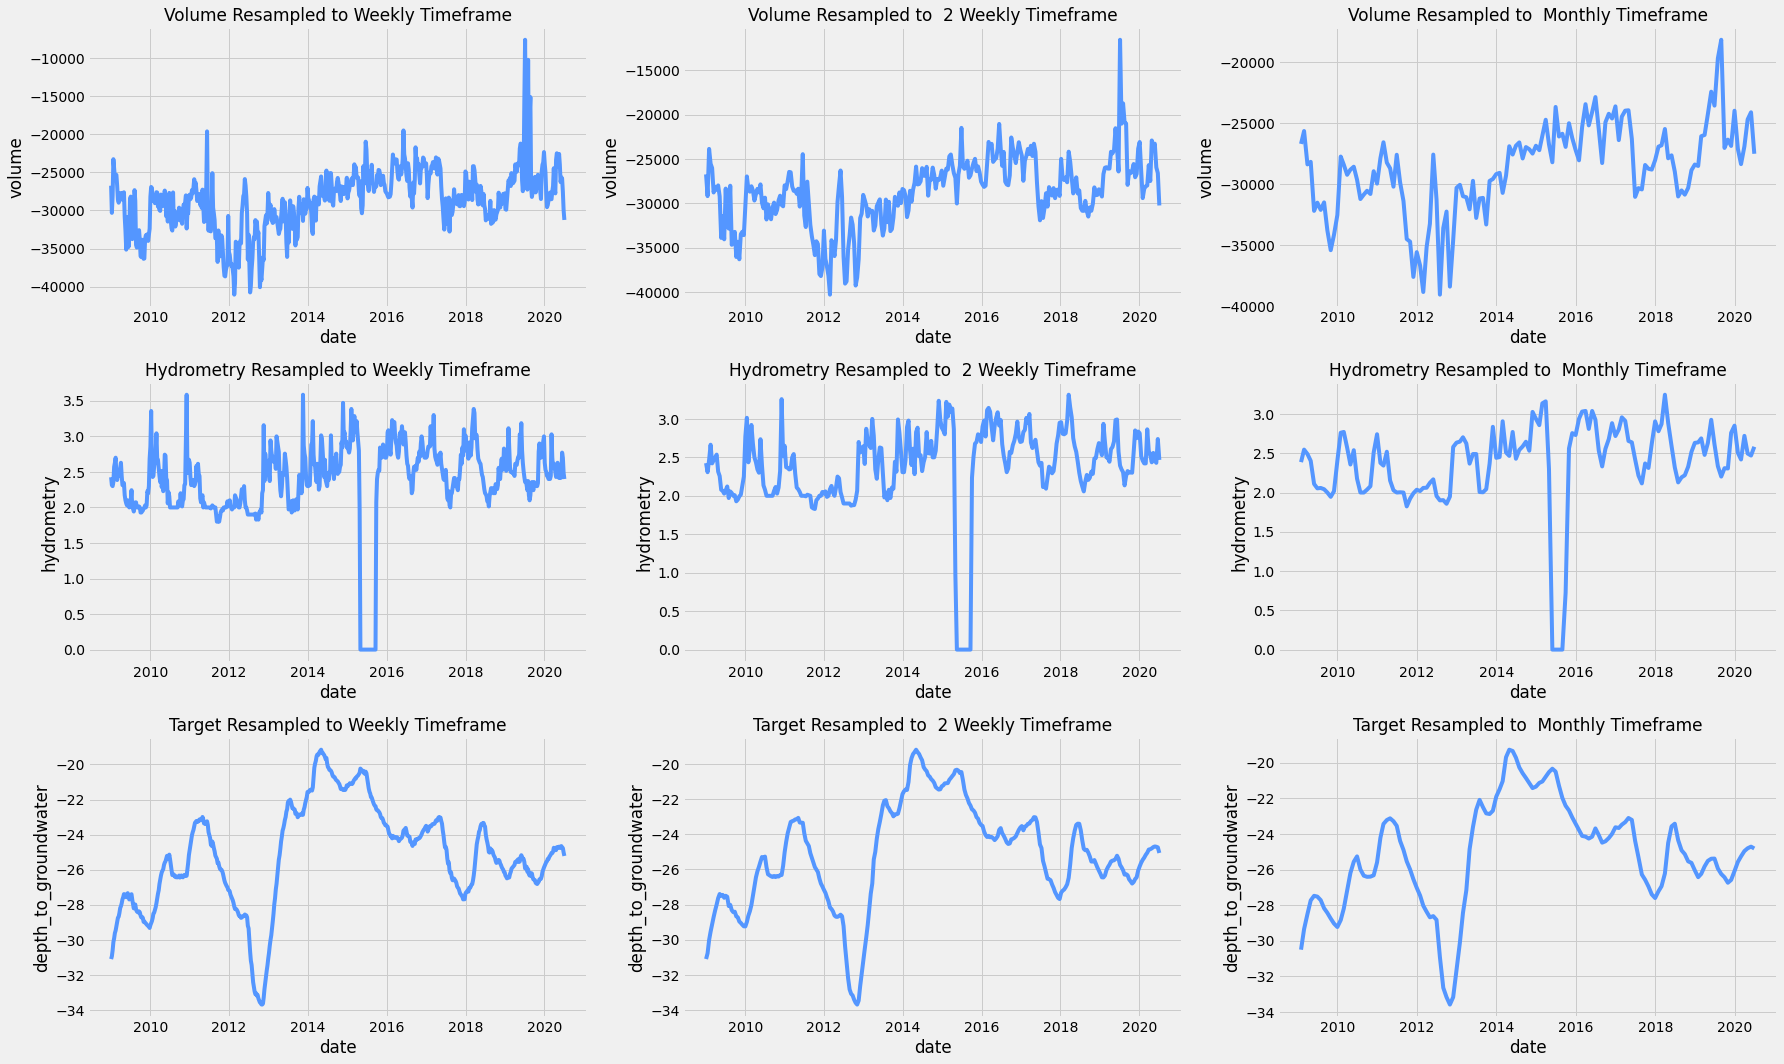

In [732]:
temp_df = df.set_index('date')
weekly_df = temp_df.resample('W').mean() # weekly 
two_weekly_df = temp_df.resample("2W").mean() # 2 weekly
monthly_df = temp_df.resample('M').mean() # monthly

fig, axes = plt.subplots(3,3, figsize=(25,15))


sns.lineplot(x=weekly_df.index, y=weekly_df['volume'], ax=axes[0,0], color='#5496ff')
axes[0,0].set_title("Volume Resampled to Weekly Timeframe", fontsize=17)

sns.lineplot(x=two_weekly_df.index, y=two_weekly_df['volume'], ax=axes[0,1], color='#5496ff')
axes[0,1].set_title("Volume Resampled to  2 Weekly Timeframe", fontsize=17)

sns.lineplot(x=monthly_df.index, y=monthly_df['volume'], ax=axes[0,2], color='#5496ff')
axes[0,2].set_title("Volume Resampled to  Monthly Timeframe", fontsize=17)

sns.lineplot(x=weekly_df.index, y=weekly_df['hydrometry'], ax=axes[1,0], color='#5496ff')
axes[1,0].set_title("Hydrometry Resampled to Weekly Timeframe", fontsize=17)

sns.lineplot(x=two_weekly_df.index, y=two_weekly_df['hydrometry'], ax=axes[1,1], color='#5496ff')
axes[1,1].set_title("Hydrometry Resampled to  2 Weekly Timeframe", fontsize=17)

sns.lineplot(x=monthly_df.index, y=monthly_df['hydrometry'], ax=axes[1,2], color='#5496ff')
axes[1,2].set_title("Hydrometry Resampled to  Monthly Timeframe", fontsize=17)

sns.lineplot(x=weekly_df.index, y=weekly_df['depth_to_groundwater'], ax=axes[2,0], color='#5496ff')
axes[2,0].set_title("Target Resampled to Weekly Timeframe", fontsize=17)

sns.lineplot(x=two_weekly_df.index, y=two_weekly_df['depth_to_groundwater'], ax=axes[2,1], color='#5496ff')
axes[2,1].set_title("Target Resampled to  2 Weekly Timeframe", fontsize=17)

sns.lineplot(x=monthly_df.index, y=monthly_df['depth_to_groundwater'], ax=axes[2,2], color='#5496ff')
axes[2,2].set_title("Target Resampled to  Monthly Timeframe", fontsize=17)

plt.tight_layout()

# Time series EDA

Visualization of seasonal quarter plot

Text(0.5, 1.0, 'Q4')

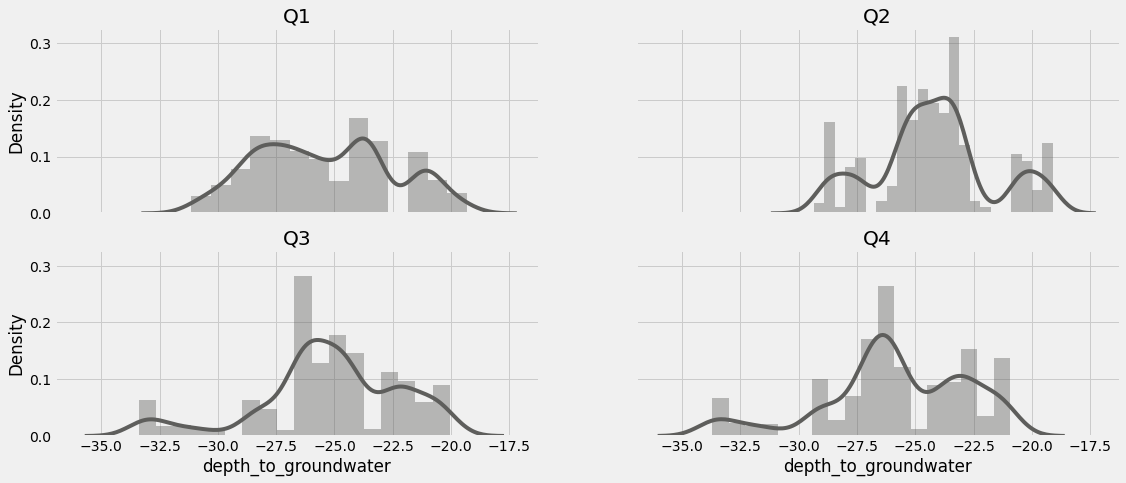

In [733]:
temp_df.reset_index(inplace=True)

temp_df['Q'] = temp_df['date'].dt.quarter

Q1 = temp_df[temp_df['Q'] == 1]
Q2 = temp_df[temp_df['Q'] == 2]
Q3 = temp_df[temp_df['Q'] == 3]
Q4 = temp_df[temp_df['Q'] == 4]

fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["depth_to_groundwater"],color='#5e5e5c', ax=axes[0,0]).set_title("Q1")
sns.distplot(Q2["depth_to_groundwater"],color='#5e5e5c', ax=axes[0,1]).set_title("Q2")
sns.distplot(Q3["depth_to_groundwater"],color='#5e5e5c', ax=axes[1,0]).set_title("Q3")
sns.distplot(Q4["depth_to_groundwater"],color='#5e5e5c', ax=axes[1,1]).set_title("Q4")

In [734]:
df_smoothed = df[['date', 'depth_to_groundwater', 'temperature', 'volume', 'hydrometry']]
df_smoothed = df_smoothed.resample('7D', on='date').mean().reset_index(drop=False)
df = df_smoothed.copy()
df.dropna(inplace=True)

df.head()

,date,depth_to_groundwater,temperature,volume,hydrometry
0,2009-01-01,-31.048571,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,5.771429,-25210.532571,2.500000


# Stationarity


Conducting Augmented Dickey-Fulle test. It is a type of statistical test called a unit root test.

- Null Hypothesis - Time series is not stationary
- Alternate Hypothesis - Time Series is stationary.

If the null hypothesis can be rejected, than it could be concluded that the time series is stationary. To filter it, p-value will be used and valued against significance level. The default significance level is 5%.

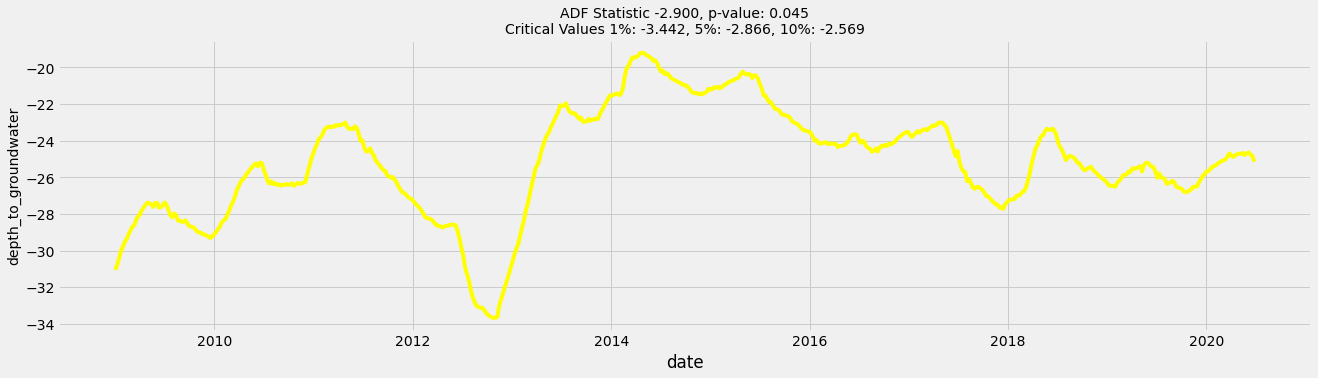

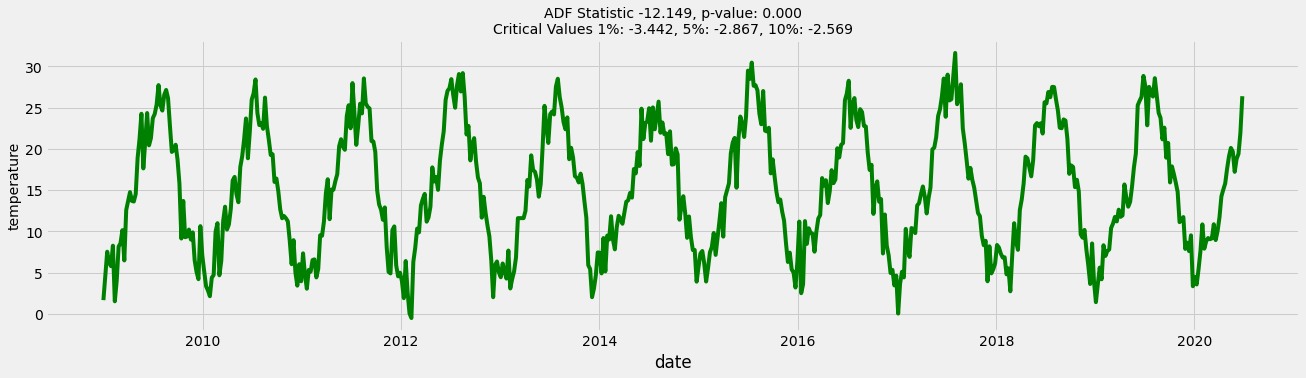

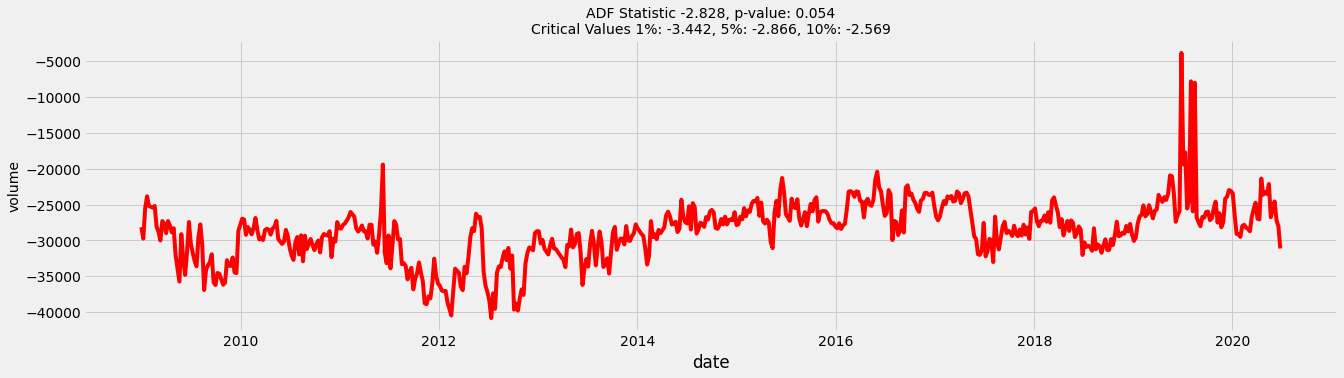

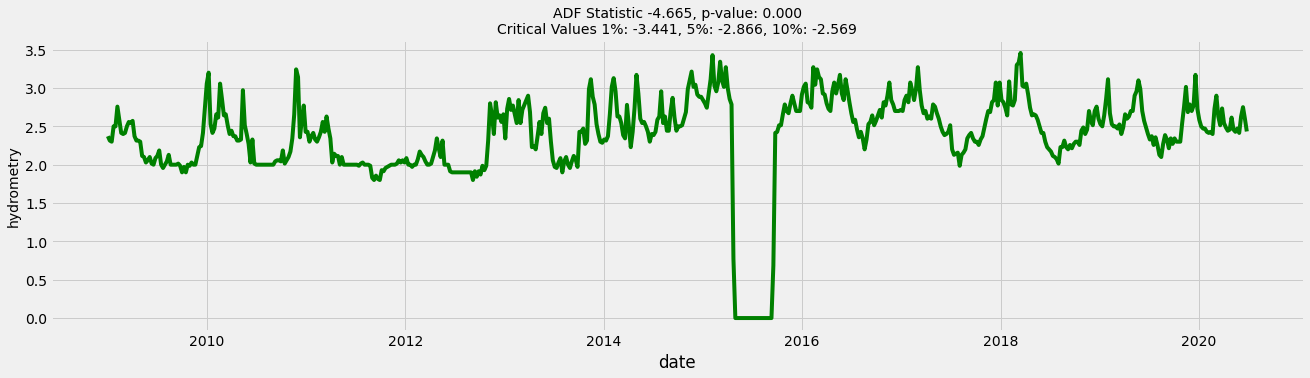

In [735]:
def adf_test(col, title):
  plt.figure(figsize=(20,5))
  result = adfuller(col)
  significance_level = 0.05
  adf_stat = result[0]
  p_val = result[1]
  critical_value_1 = result[4]['1%']
  critical_value_5 = result[4]['5%']
  critical_value_10 = result[4]['10%']

  if(p_val < significance_level) & ((adf_stat < critical_value_1)):
    linecolor='green'
  elif (p_val < significance_level) & (adf_stat < critical_value_5):
     linecolor='yellow'
  elif (p_val < significance_level) & (adf_stat < critical_value_10):
    linecolor = 'orange'
  else:
    linecolor='red'

  sns.lineplot(x=df['date'], y=col, color=linecolor)
  plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {critical_value_1:0.3f}, 5%: {critical_value_5:0.3f}, 10%: {critical_value_10:0.3f}', fontsize=14)

  plt.ylabel(ylabel=title, fontsize=14)

for i, column in enumerate(df.drop('date', axis=1).columns):
  adf_test(df[column], df.columns[i+1])
  
  plt.show()

# Visual test of stationarity

For visual check, rolling mean and std could be used to determine whether time-series data is stationary or non-stationary

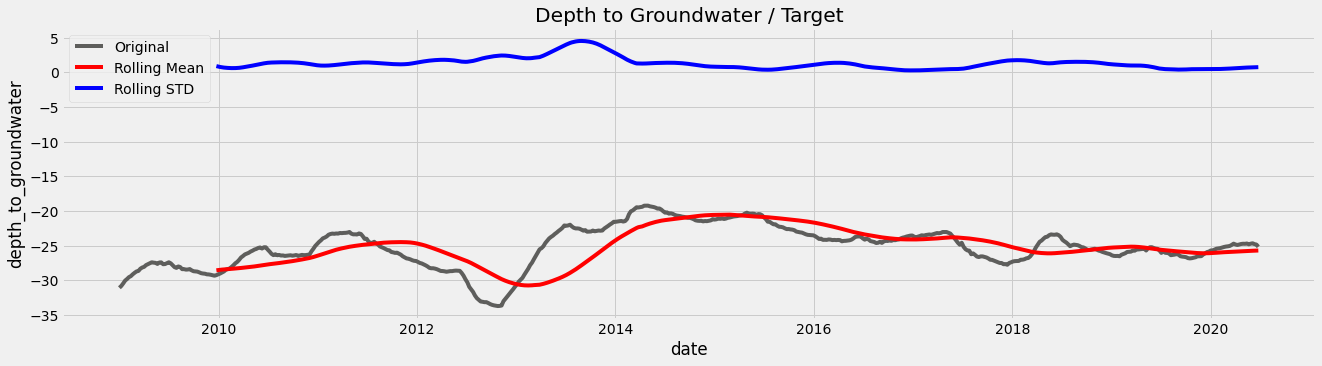

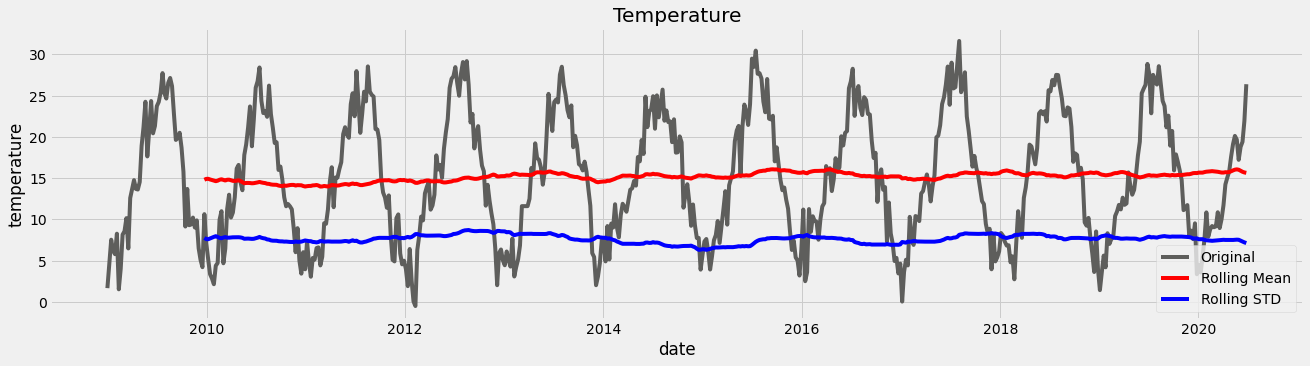

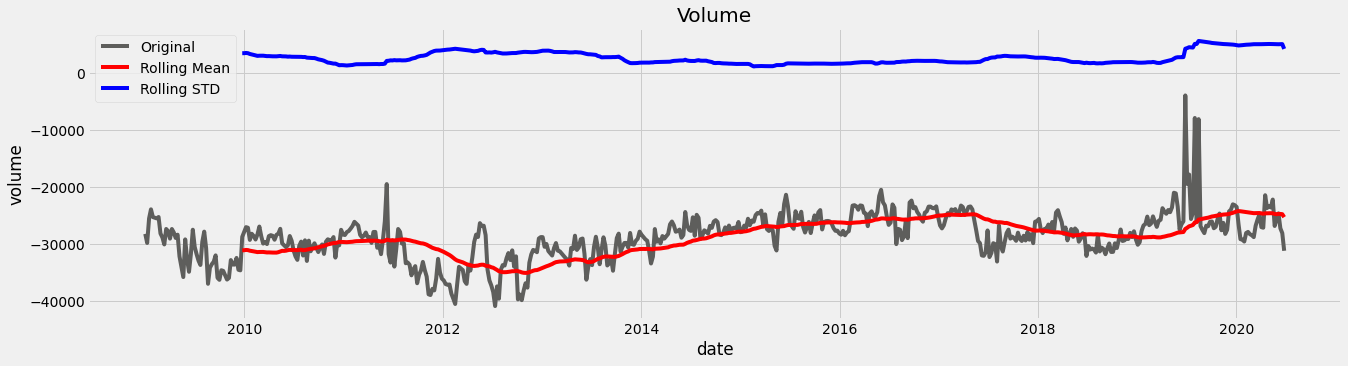

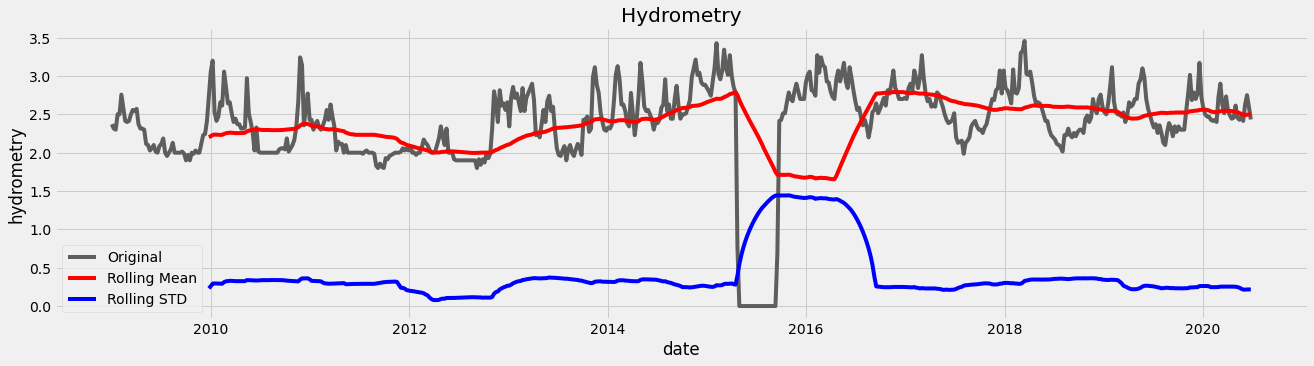

In [736]:
def plot_rolling_mean_std(timeseries, col_name):
  window = 52 

  movingAverage = timeseries.rolling(window=window).mean()
  movingSTD = timeseries.rolling(window=window).std()

  plt.figure(figsize=(20,5))
  sns.lineplot(y=timeseries, x=df['date'] ,color='#5e5e5c', label='Original')
  sns.lineplot(y=movingAverage, x=df['date'] ,color='red', label='Rolling Mean')
  sns.lineplot(y=movingSTD, x=df['date'] ,color='blue', label='Rolling STD')
  plt.legend(loc='best')
  plt.title(col_name)
  plt.show()

plot_rolling_mean_std(df['depth_to_groundwater'], 'Depth to Groundwater / Target')
plot_rolling_mean_std(df['temperature'], 'Temperature')
plot_rolling_mean_std(df['volume'], 'Volume')
plot_rolling_mean_std(df['hydrometry'], 'Hydrometry')

# Towards Stationary

Log transformation would be used in order to reduce magnitude of target variable

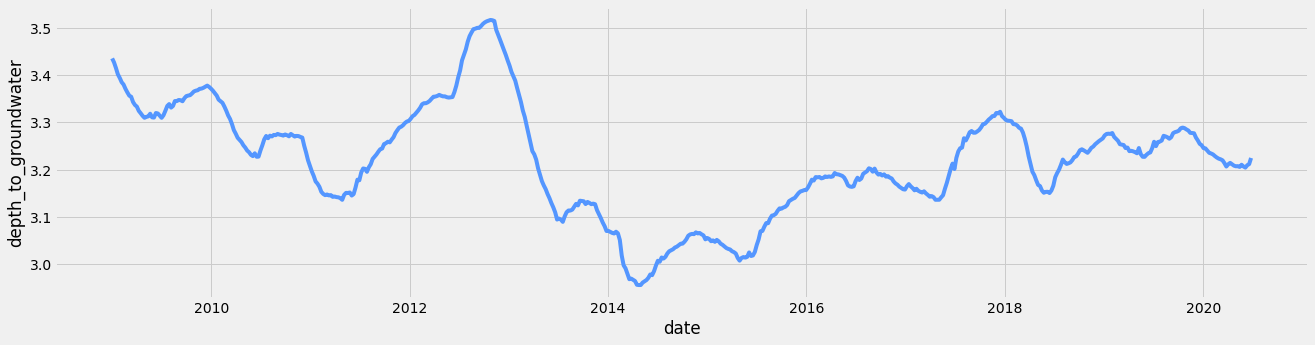

In [737]:
plt.figure(figsize=(20,5))
df['depth_to_groundwater'] = np.log(abs(df['depth_to_groundwater']))
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'], color='#5496ff')

Differencing is subtracting an observation from an observation at the previous time step. Differencing generates a time series of the changes between raw data points and helps us create a time series that is stationary. Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero. After each differencing operation, like we perform below, we can conduct an Augmented Dickey-Fuller (adf) and Kwiatkowski-Phillips-Schmidt-Shin (kpss) test to check for stationarity.

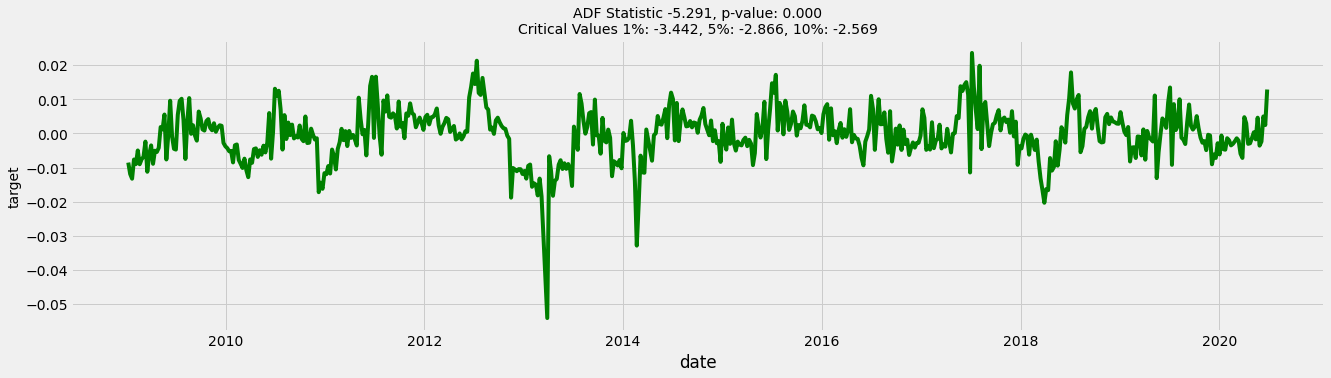

In [738]:
df['depth_to_groundwater'] = df['depth_to_groundwater'].diff()
df.dropna(inplace=True)
adf_test(df['depth_to_groundwater'], 'target') # ADF re-check of stationarity

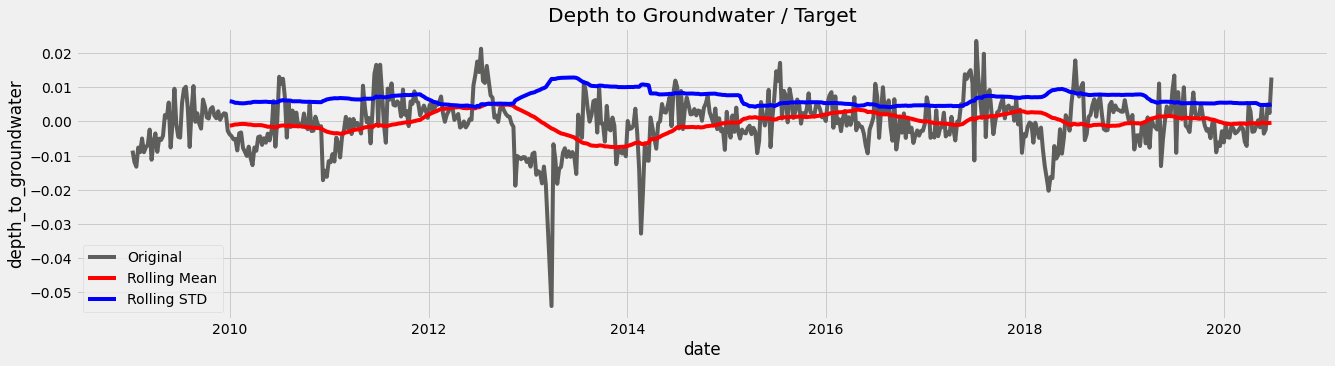

In [739]:
plot_rolling_mean_std(df['depth_to_groundwater'], 'Depth to Groundwater / Target') #Visual re-check of stationarity

# ACF/PACF

**ACT**

Correlograms can give us a good idea whether or not pairs of data show autocorrelation.

To read a correlogram the x-axis shows the lagged observations at prior time steps. So lag 1, or 1 on the x axis, is equivalent to the time step  xt−1  and the y-axis is the correlation strength between or observation  xt  and the various prior time steps, called lags.

When reading a correlogram we look at two things: the size of the correlation coefficients on the y-axis and the presence of trend. If there are high coefficients and a visible trend then autocorrelation is highly likely.

Additionally, confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this cone are very likely a correlation and not a statistical fluke.

**PACF**

A partial autocorrelation is a summary of the relationship between an observation in a time series and observations at prior time steps with the relationships of intervening observations removed. We can read it much like our ACT.


-----
Main feature of ACF/PACF is to determine number of AR/MA while building ARIMA model



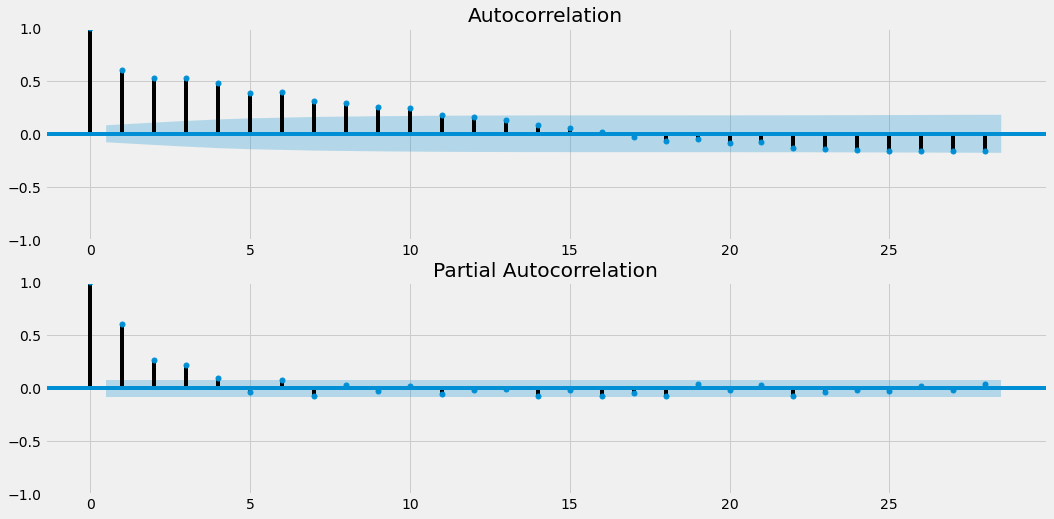

In [740]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
plot_acf(df['depth_to_groundwater'], ax=ax[0])
plot_pacf(df['depth_to_groundwater'], ax=ax[1])

plt.show()

# Modelling


Building univariate dataframe

In [741]:
univariate_df = df[['date', 'depth_to_groundwater']]
univariate_df.shape

(596, 2)

# Train/test split

For split, variables train/test would be hardcoded and approximately it would be split into 85%/15% 

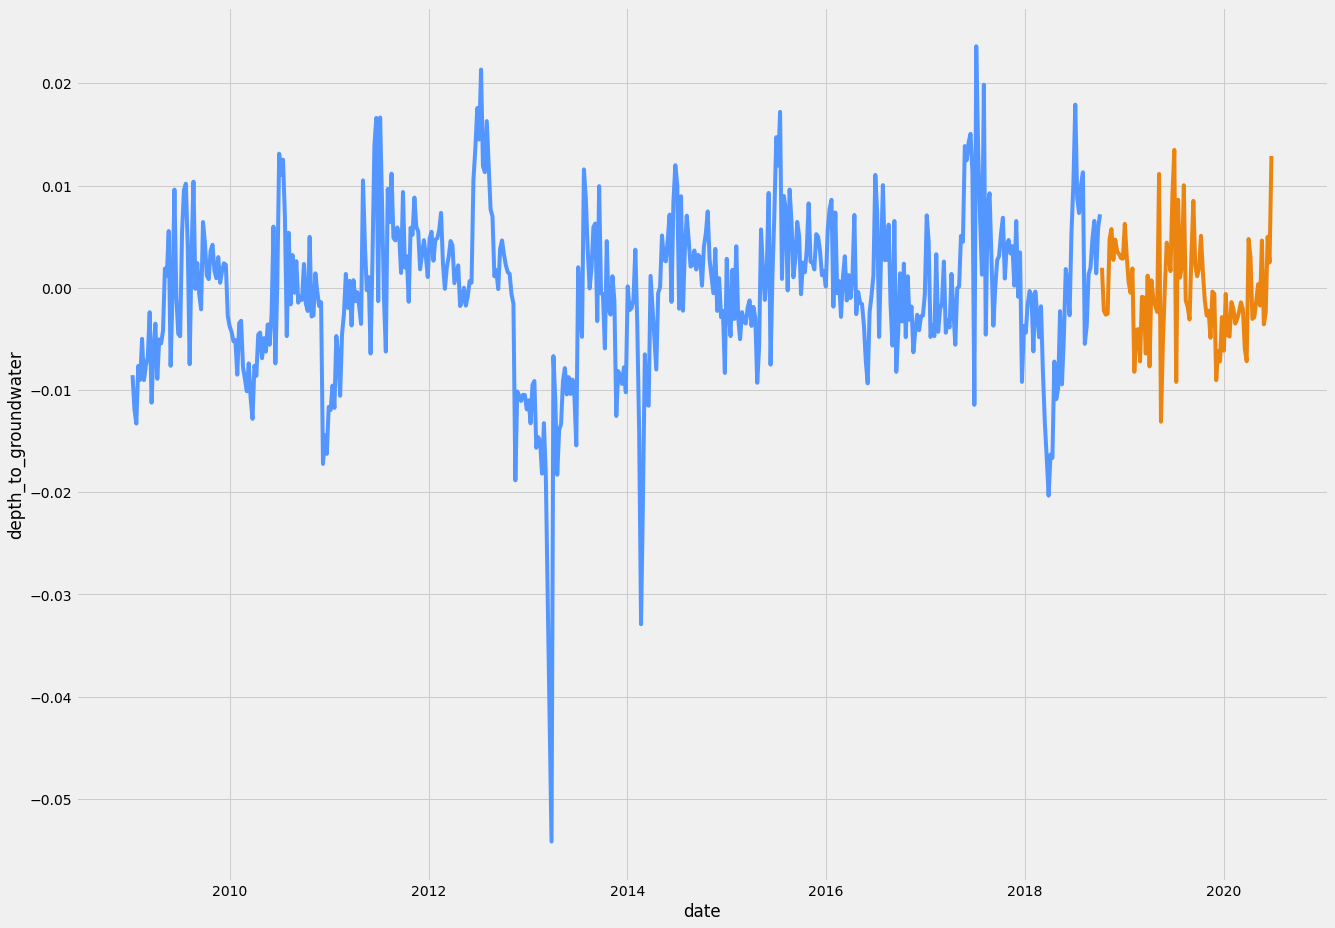

In [742]:
train = univariate_df[:506].set_index("date")
test = univariate_df[-90:].set_index("date")

plt.figure(figsize=(20,15))
sns.lineplot(x=train.index, y=train['depth_to_groundwater'], color='#5496ff')
sns.lineplot(x=test.index, y=test['depth_to_groundwater'], color='#eb8510')

# Auto-ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3802.204, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3486.976, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3743.113, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3639.047, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3638.195, Time=0.85 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3798.790, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3674.716, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3777.583, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3797.947, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3800.584, Time=0.91 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 5.436 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  506
Model:               SARIMAX(1, 0, 1)   Log Likeliho

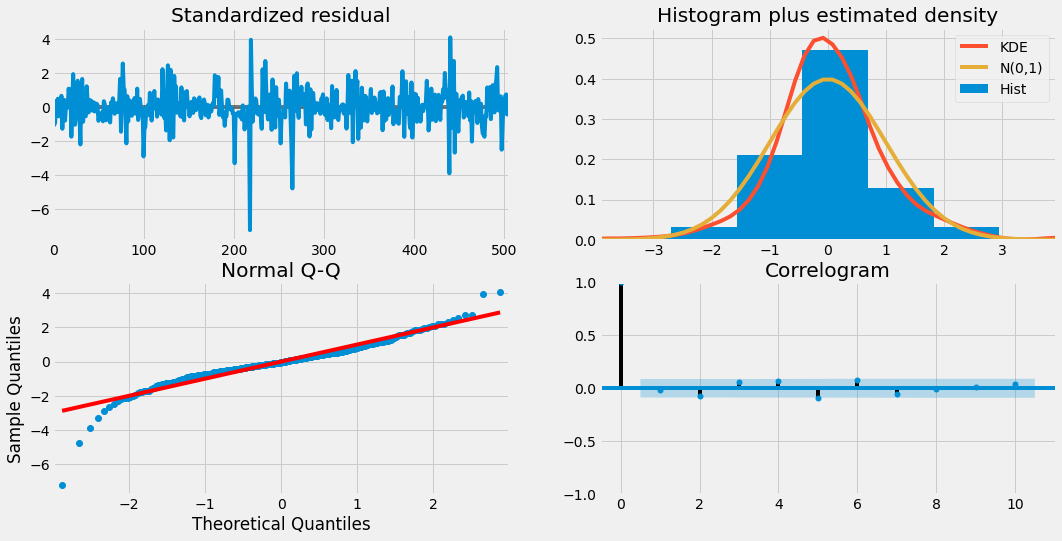

In [743]:
arima_model = auto_arima(train, start_p=1, start_q=1,
                         test='adf', max_p=5, max_q=5,
                         D=0,
                         m=1, d=None, seasonal=False,
                         trace=True,
                         error_action='ignore',
                         supress_warnings=True,
                         random_fit=42)

print(arima_model.summary())
arima_model.plot_diagnostics(figsize=(16,8))
plt.show()

In [744]:
prediction = pd.DataFrame(arima_model.predict(n_periods=90), index=test.index)
prediction.columns = ['predicted_depth_to_groundwater']
prediction

,predicted_depth_to_groundwater
date,
2018-10-11,0.004771
2018-10-18,0.004370
2018-10-25,0.004003
2018-11-01,0.003666
2018-11-08,0.003358
...,...
2020-05-28,0.000003
2020-06-04,0.000003
2020-06-11,0.000002


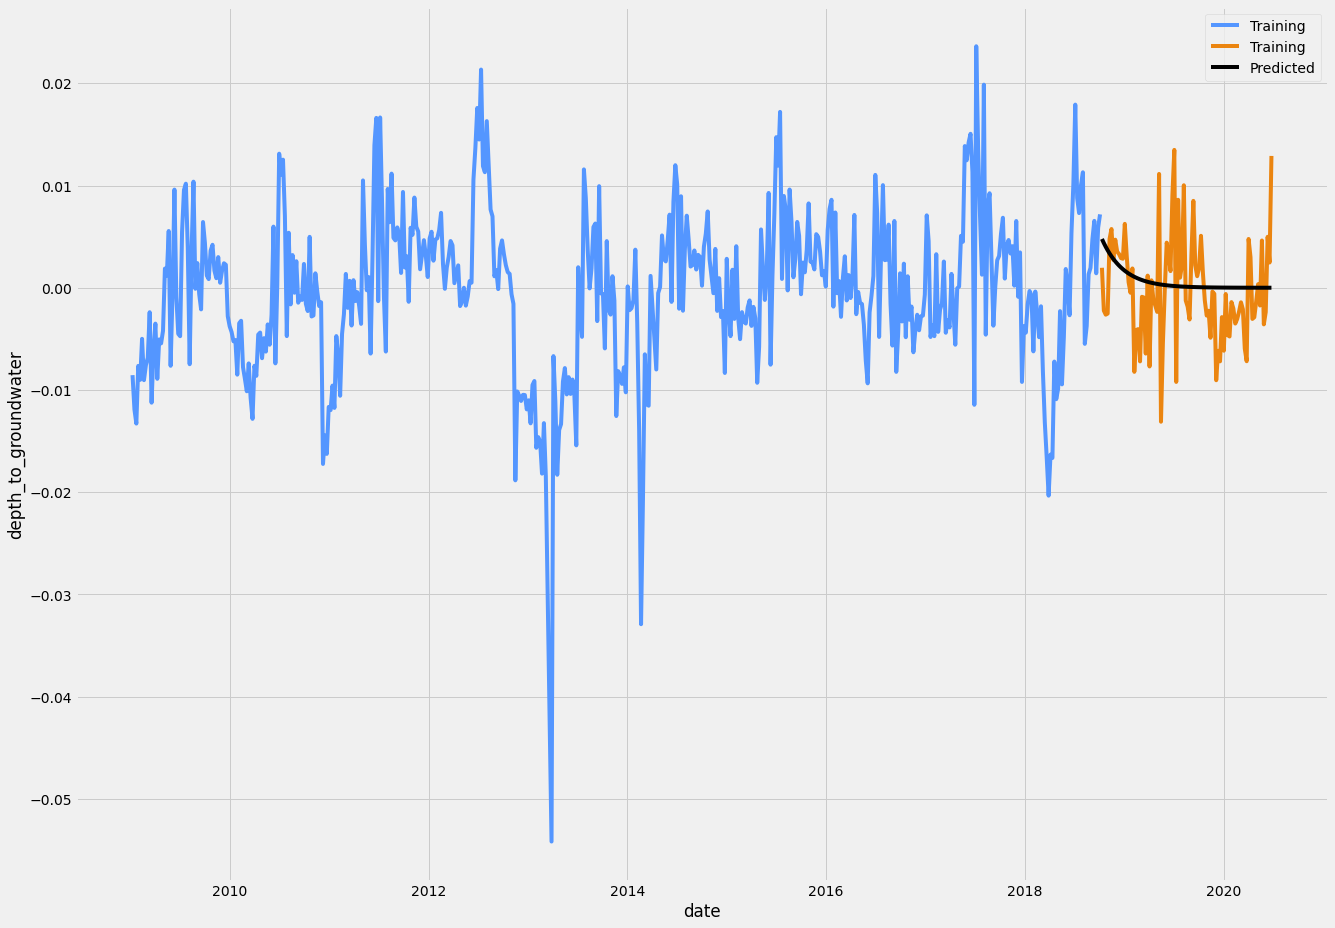

In [745]:
plt.figure(figsize=(20,15))

sns.lineplot(x=train.index, y=train['depth_to_groundwater'], label='Training', color='#5496ff')
sns.lineplot(x=test.index, y=test['depth_to_groundwater'], label='Training', color='#eb8510')
sns.lineplot(x=prediction.index, y=prediction.predicted_depth_to_groundwater, label='Predicted', color='black')
plt.show()

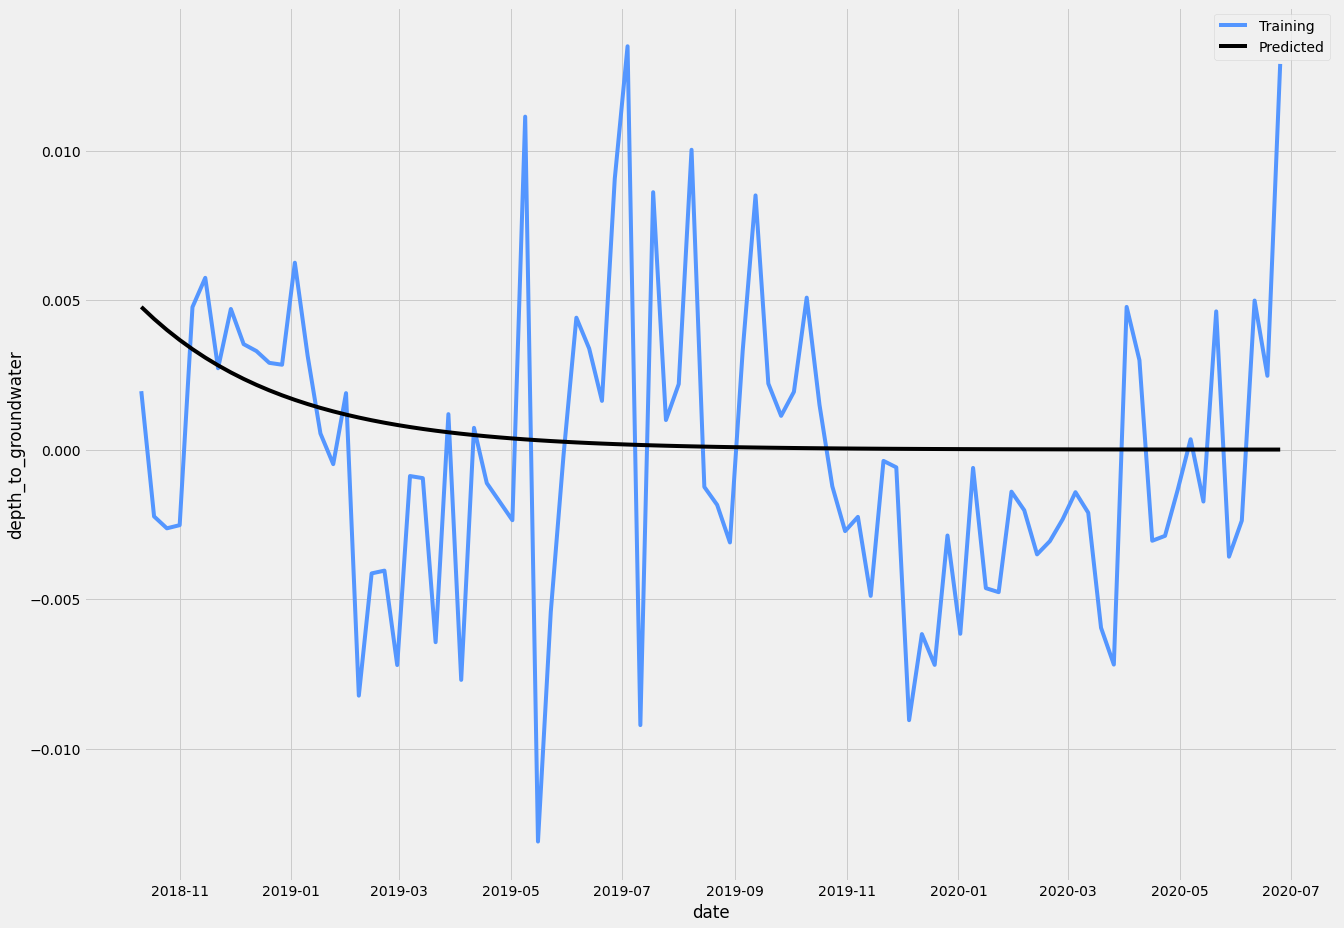

In [746]:
plt.figure(figsize=(20,15))
sns.lineplot(x=test.index, y=test['depth_to_groundwater'], label='Training', color='#5496ff')
sns.lineplot(x=prediction.index, y=prediction.predicted_depth_to_groundwater, label='Predicted', color='black')

In [747]:
score_mae_ARIMA = mean_absolute_error(test['depth_to_groundwater'], prediction['predicted_depth_to_groundwater'])
score_rmse_ARIMA = math.sqrt(mean_squared_error(test['depth_to_groundwater'], prediction['predicted_depth_to_groundwater']))

print('MAE --- >', score_mae_ARIMA)
print('RMSE --- >', score_rmse_ARIMA)

df_models = pd.DataFrame(data=[['ARIMA', score_mae_ARIMA, score_rmse_ARIMA]], columns=['Model Name', 'MAE', 'RMSE'])

MAE --- > 0.003869116590093979
RMSE --- > 0.005002667663429773


# Prophet (Univariate)

In [748]:
train.reset_index(inplace=True, drop=False)
train.columns = ['ds', 'y']
train['ds'] = pd.to_datetime(train['ds'])
train.head()

,ds,y
0,2009-01-08,-0.008548
1,2009-01-15,-0.011904
2,2009-01-22,-0.013284
3,2009-01-29,-0.007643
4,2009-02-05,-0.009008


In [749]:
model = Prophet(interval_width=0.95)
model.fit(train)
future = model.make_future_dataframe(periods=90, freq='W')

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2009-01-08,-0.004253,-0.016832,0.008141
1,2009-01-15,-0.003655,-0.016113,0.008609
2,2009-01-22,-0.003591,-0.016042,0.009638
3,2009-01-29,-0.004170,-0.016103,0.007965
4,2009-02-05,-0.005195,-0.016840,0.007940


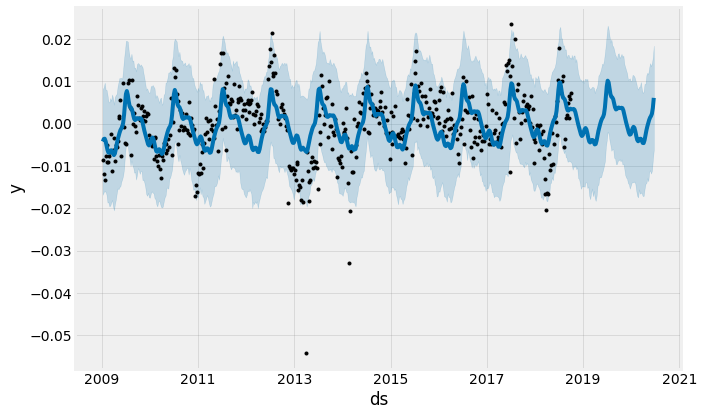

In [750]:
model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
model.plot_components(forecast)
plt.show()

In [751]:
test.reset_index(inplace=True, drop=False)
test.columns = ['ds', 'y']
test['ds'] = pd.to_datetime(test['ds'])
X_test_forecast = model.predict(test)
X_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
83,2020-05-14,0.000554,-0.011370,0.012461
84,2020-05-21,0.001209,-0.011147,0.013812
85,2020-05-28,0.001631,-0.010182,0.014655
86,2020-06-04,0.002022,-0.009845,0.014047
87,2020-06-11,0.002975,-0.009330,0.015441
88,2020-06-18,0.004949,-0.007378,0.017986
89,2020-06-25,0.007599,-0.005427,0.020327


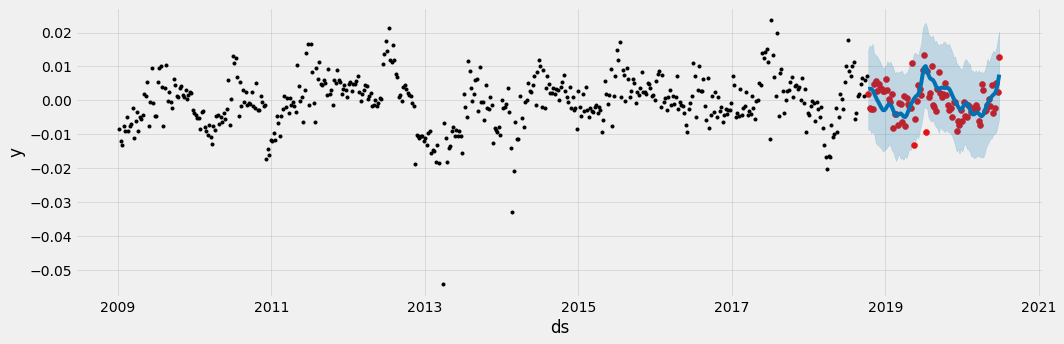

In [752]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.ds, test.y, color='#eb1010')
fig = model.plot(X_test_forecast, ax=ax)

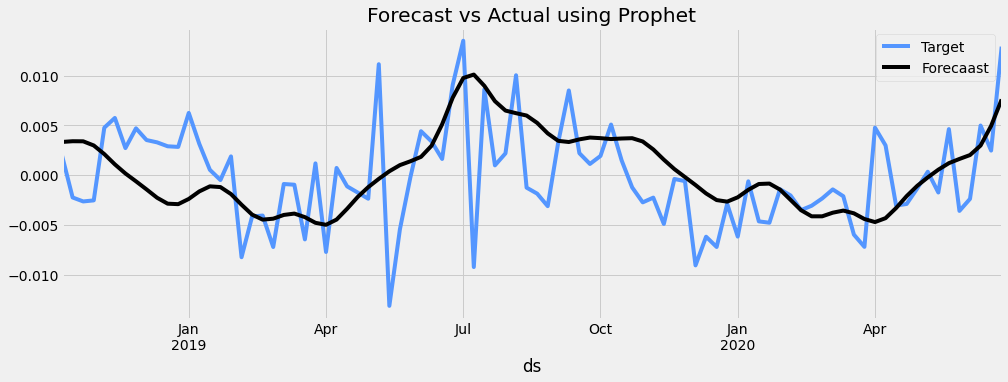

In [753]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line', x='ds', y='y', label='Target', ax=ax, color='#5496ff')
X_test_forecast.plot(kind='line', x='ds', y='yhat', color='black', label='Forecaast', ax=ax)
plt.title("Forecast vs Actual using Prophet")
plt.show()

In [754]:
score_mae_prophet_univariate = mean_absolute_error(test['y'], X_test_forecast['yhat'])
score_rmse_prophet_univariate = math.sqrt(mean_squared_error(test['y'], X_test_forecast['yhat']))

print('MAE --- >', score_mae_prophet_univariate)
print('RMSE --- >', score_rmse_prophet_univariate)

df_model_temp = pd.DataFrame(data=[['Prophet(Univariate)', score_mae_prophet_univariate, score_rmse_prophet_univariate]], columns=['Model Name', 'MAE', 'RMSE'])
df_models = df_models.append(df_model_temp, ignore_index=True)

MAE --- > 0.003714128215175384
RMSE --- > 0.00486087698600187


# Prophet (Multivariate)

In [755]:
feature_columns = ['temperature',
                   'volume',
                   'hydrometry']

target_column = ['depth_to_groundwater']

multivariate_prediction = df[['date'] + target_column + feature_columns].copy()
multivariate_prediction.columns = ['ds', 'y'] + feature_columns
train['ds'] = pd.to_datetime(train['ds'])

train = multivariate_prediction.iloc[:506, :]
test = multivariate_prediction.iloc[-90:, :] 

train.head()

,ds,y,temperature,volume,hydrometry
1,2009-01-08,-0.008548,4.571429,-29755.789714,2.314286
2,2009-01-15,-0.011904,7.528571,-25463.190857,2.300000
3,2009-01-22,-0.013284,6.214286,-23854.422857,2.500000
4,2009-01-29,-0.007643,5.771429,-25210.532571,2.500000
5,2009-02-05,-0.009008,8.257143,-25326.555429,2.757143


In [756]:
model = Prophet()
model.add_regressor('temperature')
model.add_regressor('volume')
model.add_regressor('hydrometry')
model.fit(train)
future = model.make_future_dataframe(periods=90, freq='W')

y_pred = model.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2009-01-08,-0.004253,-0.016832,0.008141
1,2009-01-15,-0.003655,-0.016113,0.008609
2,2009-01-22,-0.003591,-0.016042,0.009638
3,2009-01-29,-0.004170,-0.016103,0.007965
4,2009-02-05,-0.005195,-0.016840,0.007940


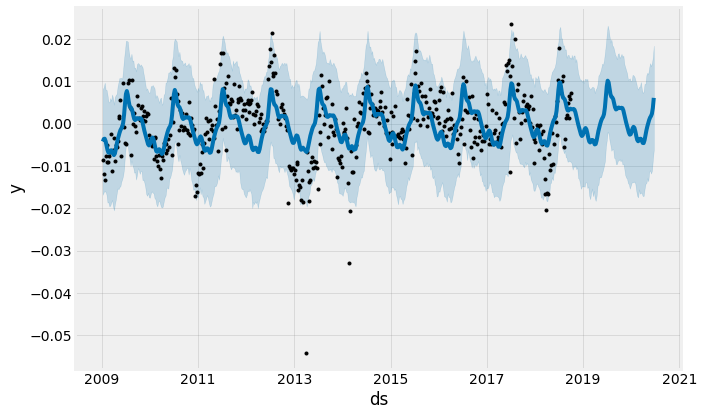

In [757]:
model.plot(forecast, uncertainty=True)
plt.show()

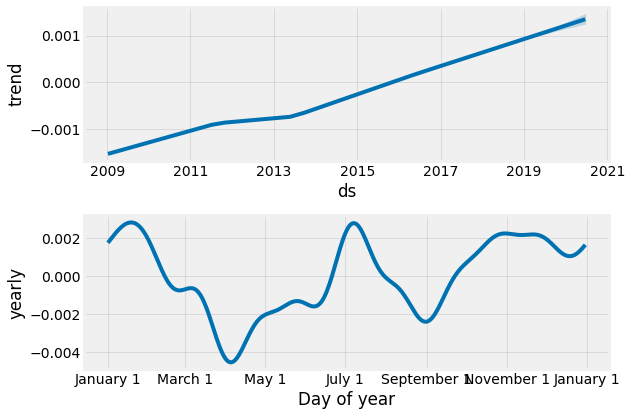

In [758]:
model.plot_components(forecast)
plt.show()

In [759]:
test.reset_index(inplace=True, drop=False)
test['ds'] = pd.to_datetime(test['ds'])
X_test_forecast = model.predict(train)
X_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
499,2018-08-23,0.003374,-0.004230,0.010275
500,2018-08-30,0.003096,-0.004341,0.010456
501,2018-09-06,0.004456,-0.002381,0.011627
502,2018-09-13,0.004428,-0.002984,0.011529
503,2018-09-20,0.003824,-0.003681,0.011069
504,2018-09-27,0.003589,-0.003609,0.011361
505,2018-10-04,0.004464,-0.003039,0.011508


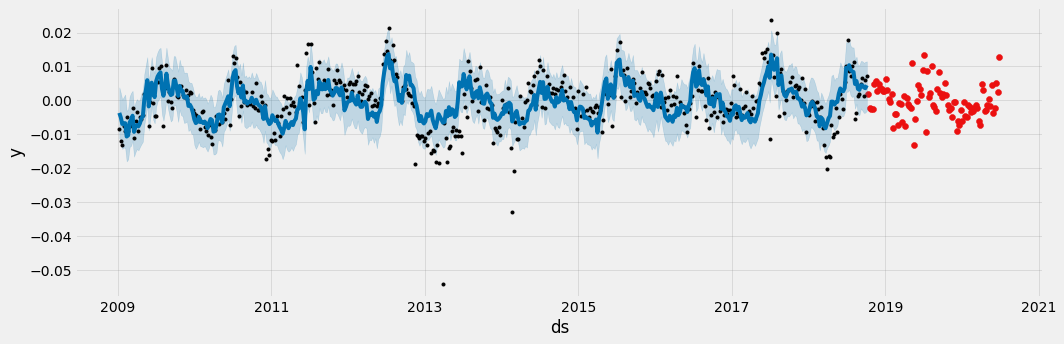

In [760]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.ds, test.y, color='#eb1010')
fig = model.plot(X_test_forecast, ax=ax)

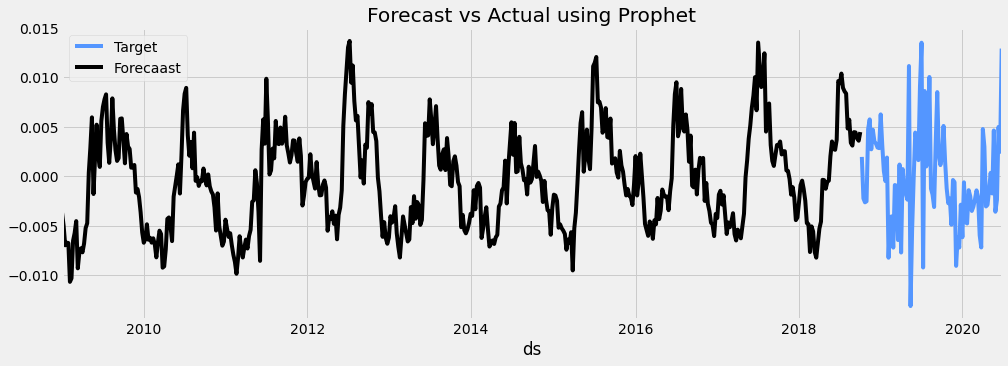

In [761]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line', x='ds', y='y', label='Target', ax=ax, color='#5496ff')
X_test_forecast.plot(kind='line', x='ds', y='yhat', color='black', label='Forecaast', ax=ax)
plt.title("Forecast vs Actual using Prophet")
plt.show()

In [764]:
score_mae_prophet_multivariate = mean_absolute_error(test['y'], y_pred['yhat'])
score_rmse_prophet_multivariate = math.sqrt(mean_squared_error(test['y'], y_pred['yhat']))

print('MAE --- >', score_mae_prophet_multivariate)
print('RMSE --- >', score_rmse_prophet_multivariate)

df_model_temp = pd.DataFrame(data=[['Prophet(Multivariate)', score_mae_prophet_multivariate, score_rmse_prophet_multivariate]], columns=['Model Name', 'MAE', 'RMSE'])
df_models = df_models.append(df_model_temp, ignore_index=True)

MAE --- > 0.004505382348477069
RMSE --- > 0.005790444341716924


In [765]:
df_models 

,Model Name,MAE,RMSE
0,ARIMA,0.003869,0.005003
1,Prophet(Univariate),0.003714,0.004861
2,Prophet(Multivariate),0.004505,0.005790
